<h1> The Importance of Personality Traits in Agile Software Development: A Case Study </h1>
<hr/>

<h2> 1.0 Developers` personality insight analysis <hr />
using the open source datasets of eoght software development teams JIRA logs </h2>

<h3>1.0.1 load libraries and datasets</h3>

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import PercentFormatter
from matplotlib.patches import Rectangle
import seaborn as sns
import re
from collections import Counter
import pandasql as ps
from apyori import apriori

In [2]:
changelog = pd.read_csv('jiradataset_changelog.csv')
issues = pd.read_csv('jiradataset_issues.csv')
sprints = pd.read_csv('jiradataset_sprints.csv')
users = pd.read_csv('jiradataset_users.csv')

<h3> 1.0.2 Check the datasets </h3>



In [48]:
changelog.head(3)

,author,created,field,fieldtype,from,fromString,key,project,to,toString
0,jvalkeal,2016-03-03 18:40:53.171,status,jira,10000,To Do,XD-3751,xd,3,In Progress
1,jvalkeal,2016-03-03 18:41:19.429,Pull Request URL,custom,NaN,NaN,XD-3751,xd,NaN,https://github.com/spring-projects/spring-xd/p...
2,jvalkeal,2016-03-03 18:41:19.429,status,jira,3,In Progress,XD-3751,xd,10006,In PR


In [50]:
issues.head(3)

,fields.assignee.name,fields.components,fields.created,fields.creator.name,fields.description,fields.fixVersions,fields.issuetype.name,fields.issuetype.subtask,fields.priority.name,fields.reporter.name,...,fields.status.name,fields.status.statusCategory.name,fields.summary,fields.updated,fields.versions,fields.watches.watchCount,key,storypoints,project,sprint
0,NaN,"[{u'id': u'12786', u'self': u'https://jira.spr...",2016-03-31T22:35:55.000+0000,thomas.risberg,"The MapReduce samples should have ""yarn.resour...",[],Improvement,False,Minor,thomas.risberg,...,To Do,To Do,"Add ""yarn.resourcemanager.scheduler.address"" t...",2016-03-31T22:35:55.000+0000,[],1,XD-3753,2.000,xd,NaN
1,NaN,"[{u'id': u'12784', u'self': u'https://jira.spr...",2016-03-14T18:09:51.000+0000,manju4ever,When i use the admin-ui web portal which runs ...,[],Bug,False,Trivial,manju4ever,...,To Do,To Do,Admin UI login Page failing to load due to req...,2016-03-14T18:09:51.000+0000,"[{u'archived': False, u'description': u'1.3.0 ...",1,XD-3752,20.000,xd,NaN
2,jvalkeal,[],2016-03-03T13:22:14.000+0000,jvalkeal,In a case where reactor's ringbuffer is full a...,[],Bug,False,Major,jvalkeal,...,In PR,In Progress,gpfdist may fail to shutdown with backlog,2016-03-03T18:41:19.000+0000,"[{u'archived': False, u'name': u'1.3.1', u'sel...",1,XD-3751,5.000,xd,NaN


In [5]:
sprints.head(3)

,key,project,sprint.completeDate,sprint.endDate,sprint.id,sprint.name,sprint.startDate,sprint.state
0,XD-3744,xd,2016-02-26T16:32:18.620Z,2016-02-26T08:34:00.000Z,108,Sprint 68,2016-02-16T00:38:45.289Z,CLOSED
1,XD-3743,xd,2016-02-26T16:32:18.620Z,2016-02-26T08:34:00.000Z,108,Sprint 68,2016-02-16T00:38:45.289Z,CLOSED
2,XD-3742,xd,2016-02-26T16:32:18.620Z,2016-02-26T08:34:00.000Z,108,Sprint 68,2016-02-16T00:38:45.289Z,CLOSED


In [6]:
users.head(3)

,Unnamed: 0,displayName,emailAddress,name,project,role,timeZone
0,0,NaN,NaN,NaN,xd,assignee,NaN
1,2,Janne Valkealahti,janne dot valkealahti at gmail dot com,jvalkeal,xd,assignee,Europe/London
2,5,Gary Russell,grussell at gopivotal dot com,grussell,xd,assignee,America/New_York


In [7]:
changelog.head(3)

,author,created,field,fieldtype,from,fromString,key,project,to,toString
0,jvalkeal,2016-03-03 18:40:53.171,status,jira,10000,To Do,XD-3751,xd,3,In Progress
1,jvalkeal,2016-03-03 18:41:19.429,Pull Request URL,custom,NaN,NaN,XD-3751,xd,NaN,https://github.com/spring-projects/spring-xd/p...
2,jvalkeal,2016-03-03 18:41:19.429,status,jira,3,In Progress,XD-3751,xd,10006,In PR



<h3>1.1 Check the datasets for the manually written textual values</h3>
<h5>1.1.1 within 'changelog' take two examplary row values from each unique field, store into dataframe, export into csv and check manually</h5>

In [8]:
# declare the empty series
i_row = []
field_row = []
from_row = []
to_row = []
from_string_row = []
to_string_row = []

# loop through each unique field, take top two values from the columns 'fromString', 'toString', 'from' and 'to'
# append these two values to the respective series
# create dataframe 'df' with these filled series, and export it to .csv file, and check it manually.
i = 1
for field in changelog['field'].unique():
    from_str = changelog[changelog['field'] == field]['fromString'].head(2)
    from_ = changelog[changelog['field'] == field]['from'].head(2)
    to_str = changelog[changelog['field'] == field]['toString'].head(2)
    to_ = changelog[changelog['field'] == field]['to'].head(2)
    i_row.append(i)
    field_row.append(field)
    from_row.append(from_str)
    to_row.append(to_str)
    from_string_row.append(from_)
    to_string_row.append(to_)
    i = i + 1
df = pd.DataFrame({'id':i_row,
                   'field':field_row, 
                   'from':from_row, 
                   'to':to_row, 
                   'fromString':from_string_row, 
                   'toString':to_string_row })
df.to_csv('fields_check.csv')
df.head()

,id,field,from,to,fromString,toString
0,1,status,0 To Do 2 In Progress Name: fromSt...,0 In Progress 2 In PR Name: toStri...,"0 10000 2 3 Name: from, dtype: object","0 3 2 10006 Name: to, dtype: object"
1,2,Pull Request URL,"1 NaN 13 NaN Name: fromString, dtype: o...",1 https://github.com/spring-projects/sprin...,"1 NaN 13 NaN Name: from, dtype: object","1 NaN 13 NaN Name: to, dtype: object"
2,3,summary,3 Can completely remove module after puttin...,3 Can completely remove custom module after...,"3 NaN 5 NaN Name: from, dtype: object","3 NaN 5 NaN Name: to, dtype: object"
3,4,issuetype,"4 Story 17 Story Name: fromString, dtyp...",4 Bug 17 Improvement Name: toSt...,"4 8 17 8 Name: from, dtype: object","4 1 17 4 Name: to, dtype: object"
4,5,description,7 Custom conversion is broken.\r\r\n\r\r\nI...,7 Custom conversion is broken.\r\r\n\r\r\nI...,"7 NaN 8 NaN Name: from, dtype: object","7 NaN 8 NaN Name: to, dtype: object"


**After checking the fields, detected the ones withthe written textual values:** <hr/>
*'summary', 'description', 'Acceptance Criteria', 'Comment', 'Epic Name',
 'Out of Scope', 'QA Test Plan', 'Epic/Theme', 'Migration Impact', 'Business Value'*

<h3> 1.2 Prepare 'changelog' dataset with needed columns  </h3> <hr/>
Since the jira tasks dataset only have one reporter for each jira task, we need to find the author of actual changes of the textual fields with change log file, as in changelog every action is stored and the author of the change is tracked. 

In [9]:
# filter changelog with the textual fields
log_filtered = changelog[changelog['field'].isin(['summary', 'description', 'Acceptance Criteria', 'Comment', 'Epic Name',
 'Out of Scope', 'QA Test Plan', 'Epic/Theme', 'Migration Impact', 'Business Value'])]

# take only necessary columns - key (Jira task unique key-name), project (one of the eight project codes), 
# author (author of change), field (what field has been changed), created (date of the change action),
# toString (what textual value was assigned to the field), 
# and from(what was the value of the field, this only works for comments)

cols = ['key', 'project', 'author', 'field', 'created', 'toString', 'from']
log_cols = log_filtered[cols].copy(deep=True)
log_cols[log_cols['field']!='Comment']['from'] = np.NaN
log_cols['text'] = log_cols['from'].combine_first(log_cols['toString'])

newcols = ['key', 'project', 'author', 'field', 'created', 'text']
log_cols = log_cols[newcols]
log_cols.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


,key,project,author,field,created,text
3,XD-3750,xd,aliiqbal,summary,2016-02-29 10:00:55.086,Can completely remove custom module after putt...
5,XD-3750,xd,aliiqbal,summary,2016-02-29 10:03:14.662,Can completely remove custom module after putt...
6,XD-3750,xd,aliiqbal,summary,2016-03-13 10:24:15.636,Cant completely remove custom module after put...
7,XD-3749,xd,grussell,description,2016-02-26 15:59:57.698,Custom conversion is broken.\r\r\n\r\r\nIf the...
8,XD-3749,xd,grussell,description,2016-02-26 16:01:28.028,Custom conversion is broken.\r\r\n\r\r\nIf the...


<h3> 1.3. Get the unique textual values </h3> 
<br>discard all the duplicated texts, keep only the latest edits of the fields

In [10]:
#1. in descriptions: only leave the latest edited descriptions per unique project key. 
###(get uniques issues, join log with 'project', 'key', 'status' and get the lates onr by created date.)
log_grouped = log_cols.groupby((['project', 'key', 'field', 'author'])).agg({'created':'max'})
log_grouped.reset_index(level= [0,1,2], inplace=True)

latest_logs_from_issues = pd.merge(log_cols, log_grouped, how = 'inner',
                                   left_on = ['project', 'key', 'field', 'created'],
                                   right_on = ['project', 'key', 'field', 'created'])

print(log_cols.shape[0], log_grouped.shape[0], latest_logs_from_issues.shape[0]) 
log_cols = latest_logs_from_issues

12280 9050 9050


In [11]:
# let's export the dataset before cleaning values, to compare afterwards.
log_cols.to_csv('original_text_cols.csv')
log_cols.head(3)

,key,project,author,field,created,text
0,XD-3750,xd,aliiqbal,summary,2016-03-13 10:24:15.636,Cant completely remove custom module after put...
1,XD-3749,xd,grussell,description,2016-02-26 16:01:28.028,Custom conversion is broken.\r\r\n\r\r\nIf the...
2,XD-3748,xd,dgarcia,description,2016-02-24 10:51:45.747,If I try to use <int:message-history/> when de...


<h3>1.4 Clean the texts from the unwanted parts and characters </h3> <br>
Develoeprs tend to write the code snippets, error messages, system logs and traces and other kinds of technical information into the Jira system. On the other hand, to get the personality insights from the texts written by the developers, we need to have clean texts, therefore we need to detect and remove all the unneccessary parts from the texts.

In [12]:
# remove the whitespaces. 
#### ----  Clean the texts: remove the bad characters / similar to trim
log_cols['text'] = log_cols['text'].str.replace('\n', ' ')
log_cols['text'] = log_cols['text'].str.replace('\r', ' ')
log_cols['text'] = log_cols['text'].str.replace('\t', ' ')
log_cols['text'] = log_cols['text'].str.replace('\s', ' ')

In [13]:
### --- Clean the texts: 
def removeCodeSnippet(text):
    text = str(text).replace('&nbsp;', ' ')
    text = str(text).replace('sp_executesql', ' ')
    text = str(text).replace('exec', ' ')
    # remove not formatted code and trace part
    text = re.sub("{noformat}(.+?){noformat}", '', str(text)) 
    # remove code snippet (Both, {code} and {code: [programming language]}:
    text = re.sub("{code(.+?){code}", '', str(text)) 
    # remove html tags:
    text = re.sub("<(.+?)>", '', str(text))
    # remove another type code snippets:
    text = re.sub("{{(.+?)}}", '', str(text))
    #remove tags
    text = re.sub("{(.+?)}", '', str(text))
    #remove java calls 
    text = re.sub('"jdbc(.+?)"', " ", str(text))
    # remove module calls
    text = re.sub('"module(.+?)"', '', str(text)) 
    # remove job calls
    text = re.sub('"job(.+?)"', '', str(text)) 
    # remove SQL Begin-end transactions
    text = re.sub('\s*(B|b)(egin|EGIN)\s+.+\s+(E|e)(nd|ND)\s*', '', str(text))
    # remove SQL SELECT Statements
    text = re.sub('\s*(s|S)(elect|ELECT).+(f|F)(rom|ROM)\s*\S+(\s*(w|W)(here|HERE)\s*\S+\s*\S*\s*\S*\s|)', ' ', str(text))
    # remove SQL INSERT statements
    text = re.sub('\s*(I|I)(nsert|NSERT)\s*(I|i)(nto|NTO)\s+.+(V|v)(alues|ALUES)\s*.+\(.+\)\s*', ' ', str(text)) 
    # remove SQL DELETE statements
    text = re.sub('\s*(d|D)(elete|ELETE)\s*(f|F)(rom|ROM)\s*\S+(\s*(w|W)(here|HERE)\s*\S+\s*\S*\s*\S*\s|)', '***', str(text)) 
    # remove system version information part
    text = re.sub('[*][*][*]Version(.+?)[*][*][*]', '***', str(text)) 
    # remove deployment system descriptions
    text = re.sub('[*][*][*]Describe XD Deployment(.+?)[*][*][*]', '***', str(text)) 
    #remove system component descriptions
    text = re.sub('[*][*][*]Describe Other Components(.+?)[*][*][*]', '***', str(text)) 
    # remove system generated headers within description
    text = text.replace('***Description', '')
    text = text.replace('***Steps to recreate the problem', '')
    text = text.replace('***Error Message:', '')
    # remove square brakets with one word in it (since they are tags)
    text = re.sub('\[([^[\]{}()]+?)\]', '', str(text))
    #remove web links:
    text = re.sub('http[s]?://\S+', ' ', str(text))
    #remove local path links (with slashes)
    text = re.sub('\S+?(?=\/)\/\S*\/\S*', ' ', str(text))
    #remove local path links (with backslashes)
    text = re.sub(r'\S+?(?=\\)\\\S*\\\S*', " ", str(text))    
    #remove logs within asterisks
    text = re.sub('\*{50,}(.+?)\*{50,}', ' ', str(text)) 
    text = re.sub('\*+(.+?)\*+', ' ', str(text))
    #remove text with more than 18 character, that usually are the command codes. 
    text = re.sub('.\S{15,}.', " ", str(text))  
    # remove email addresses and commands containing @ (mainly used as sql function parameter)
    text = re.sub('(\s|\S+(?=@))@\S*', " ", str(text))
    #remove  call commands with "--"
    text = re.sub("--(\s{0,1})\S*", '', str(text))
    #remove  call commands with "-" - PROBLEM it can also delete normal words that are listed
    #text = re.sub("-\S*", '', str(text))
    # remove call commands with "--"
    text = re.sub("~(\s{0,1})\S*", '', str(text))
    # remove sql SELECT statements
    text = re.sub('SELECT\s\S+\sFROM\s\S+\s(WHERE\s\S+\s\S+\s\S|)*', '', str(text))
    # remove websites and one dotted version numbers
    text = re.sub('\S+\.\S+', '', str(text))
    # remove words containing :
    text = re.sub('\S+\:\S+', '', str(text))
    # remove command words and versions
    text = re.sub('\S*(_|-|:|\.)\S*(_|-|:|\.)\S+', '', str(text))
    # remove multiple 'at' left after the code snippets cleaning
    text = text.replace('at at ', ' ') 
    #remove multiple whitespaces (needed for removing 'at at' texts, regex is the next command below)
    text = re.sub("\s{2,}", ' ', str(text))
    # remove multiple 'at'
    text = re.sub('at\sat\s', ' ', str(text))
    # remove the non-textual characters
    text = re.sub(r'(\||~|=|>|_|\[|\]|{|}|--|\/|\\|#)', ' ', str(text))
    # remove non-unicode characters
    text = re.sub(r'[^\x00-\x7F]+','', text)
    # remove dates:
    text = re.sub('[0-9][0-9](-|\\|.|\/| )([0-9][0-9]|Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)(-|\\|.|\/| )[0-9][0-9][0-9][0-9] [0-9][0-9]:[0-9][0-9]:[0-9][0-9]', " ", str(text))
    text = re.sub('[0-9][0-9](-|\\|.|\/| )([0-9][0-9]|Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)(-|\\|.|\/| )[0-9][0-9][0-9][0-9]', " ", str(text))
    text = re.sub('[0-9][0-9](-|\\|.|\/| )([0-9][0-9]|Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)(-|\\|.|\/| )[0-9][0-9]', " ", str(text))
    text = re.sub('[0-9][0-9][0-9][0-9](-|\\|.|\/| )([0-9][0-9]|Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)(-|\\|.|\/| )[0-9][0-9] [0-9][0-9]:[0-9][0-9]:[0-9][0-9]', " ", str(text))
    text = re.sub('[0-9][0-9][0-9][0-9](-|\\|.|\/| )([0-9][0-9]|Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)(-|\\|.|\/| )[0-9][0-9]', " ", str(text))
    #remove multiple whitespaces
    text = re.sub("\s{2,}", ' ', str(text))
    
    return text

apply defined cleaning regex functions to actual text

In [14]:
log_cols['text'] = log_cols['text'].apply(removeCodeSnippet)
log_cols['text'] = log_cols['text'].apply(lambda x: str.strip(x))

In [15]:
#Check the number of rows per field type
print(log_cols.groupby('field').size())

field
Acceptance Criteria      97
Business Value            1
Comment                 522
Epic Name                57
Epic/Theme              414
Migration Impact          6
Out of Scope             10
QA Test Plan             21
description            4227
summary                3695
dtype: int64


Based on the number of values, we can ignore all the fields except ***'summary', 'description', 'Comment',
                                            'Acceptance Criteria', 'Migration Impact', 'QA Test Plan', 'Out of Scope'***
let's export and manually check each of these separately

In [16]:
log_cols = log_cols[log_cols['field'].isin(['summary', 'description', 'Comment',
                                            'Acceptance Criteria', 'Migration Impact', 'QA Test Plan', 'Out of Scope'])]
# create datasets for each field type
descriptions = log_cols[log_cols['field'] == 'description']
summaries = log_cols[log_cols['field'] == 'summary']
comments = log_cols[log_cols['field'] == 'Comment']

<h3> 1.5 filter the dataset rows </h3> <hr/>
Add the text length column into the combined dataframe

In [17]:
# detect very long texts. likely, these are log traces, we can eliminate from them.
log_cols['textLength'] = log_cols['text'].str.len()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Check dataset for visible outliers 

In [18]:
log_cols.sort_values('textLength', ascending=False).head(20)

,key,project,author,field,created,text,textLength
3923,MESOS-830,mesos,greggomann,description,2015-08-03 21:14:43.067,Identify the cause of the following test failu...,13503
1861,DNN-7299,dnn,zyhfish,description,2015-07-28 02:39:58.500,Clean build warnings in platform solution. War...,8622
3801,MESOS-2324,mesos,xujyan,description,2015-02-09 21:26:05.755,Using temporary directory I0206 15065 Opened d...,7666
2763,APSTUD-4677,apstud,ingo,description,2012-04-23 11:32:44,I've already tried to start Aptana as administ...,7001
7794,TISTUD-6258,tistud,cwilliams,Comment,2014-07-10 14:08:40,"Unless I'm missing it, there is no way to atta...",6599
2689,APSTUD-4842,apstud,cwilliams,description,2012-05-29 11:13:24.000,Option JSHint Option a label ' ' is a statemen...,5648
2157,DNN-5978,dnn,francesco.rivola,description,2015-12-11 16:27:32.060,"- Installed with CE - Log in as Host, in Host ...",4121
1877,DNN-7231,dnn,KenGrierson,Comment,2015-08-21 18:00:19.634,Upload a few dozen .txt files with unique file...,4093
5691,TIMOB-18956,timob,patakijv,description,2015-05-26 21:42:06,The documentation confirms that this is missin...,3635
1640,DNN-8141,dnn,george.alatrash,description,2015-12-22 00:45:21.859,A moniker is a simple name provided for an obj...,3537


In [19]:
#remove outliers
# I have checked them manually, 
#these are the ones that the text cleaning functions could not properly clean and contain mostly the code snippet or logs
#log_cols = log_cols.drop([3923, 1861, 3801, 2763, 7794, 2157])

Export dataset to csv file and explore manually

In [20]:
log_cols.to_csv('log_cols.csv')

Plot the distribution of all text lengths.
also let's take a look at the distribution of the text lengths which falls in the top 90% of all values, the bottom 10% of the values and the ones that fall in between.

In [21]:
cut_val = round((int(log_cols.shape[0]) * 0.05))
cut_val_top_length = log_cols.sort_values('textLength', ascending=False).head(cut_val).iloc[cut_val-1].textLength
cut_val_bottom_length = log_cols.sort_values('textLength', ascending=True).head(cut_val).iloc[cut_val-1].textLength

print('nr of rows from 5% to 95%: ', log_cols[(log_cols['textLength']<cut_val_top_length) & (log_cols['textLength']>cut_val_bottom_length)].shape[0])
print('nr of rows above 95% and minimum length of them: ', log_cols[log_cols['textLength']>=cut_val_top_length].shape[0], cut_val_top_length)
print('nr of rows below 5% and maximum length of them: ',log_cols[log_cols['textLength']<=cut_val_bottom_length].shape[0], cut_val_bottom_length)
print('Total number of rows in dataset', log_cols.shape[0])

nr of rows from 5% to 95%:  7707
nr of rows above 95% and minimum length of them:  429 839
nr of rows below 5% and maximum length of them:  442 24
Total number of rows in dataset 8578


Define the histogram plot function that shows percentage of each bin

In [54]:
def hist_with_perc(_data1, _bins1, _title1, _xlabel, _ylabel, _color,
                  _data2, _bins2, _title2, 
                  _data3, _bins3, _title3, 
                  _data4, _bins4, _title4):

    fig = plt.figure(figsize=(16, 10))
    for i in range(0, 4):
        if i ==0:
            _data=_data1
            _bins=_bins1
            _title=_title1
        elif i ==1:
            _data=_data2
            _bins=_bins2
            _title=_title2
        elif i ==2:
            _data=_data3
            _bins=_bins3
            _title=_title3
        elif i ==3:
            _data=_data4
            _bins=_bins4
            _title=_title4
        ax = fig.add_subplot(2,2,i+1)
        counts, bins, patches = ax.hist(_data, facecolor=_color, edgecolor='gray', bins=_bins)
        ax.set_xticks(bins.round(0))
        plt.xticks(rotation=45)
        plt.title(_title, fontsize=20)
        plt.ylabel(_ylabel, fontsize=15)
        plt.xlabel(_xlabel, fontsize=15)
        plt.subplots_adjust(bottom=0.15, hspace=0.5)
        bin_x_centers = 0.5 * np.diff(bins) + bins[:-1]
        bin_y_centers = ax.get_yticks()[1] * 0.25
        for i in range(len(bins)-1):
            bin_label = "{0:,}".format(counts[i]) + "  ({0:,.2f}%)".format((counts[i]/counts.sum())*100)
            plt.text(bin_x_centers[i], bin_y_centers, bin_label, rotation=90, rotation_mode='anchor')
    plt.savefig('textlengths.jpg')
    plt.show()    
    

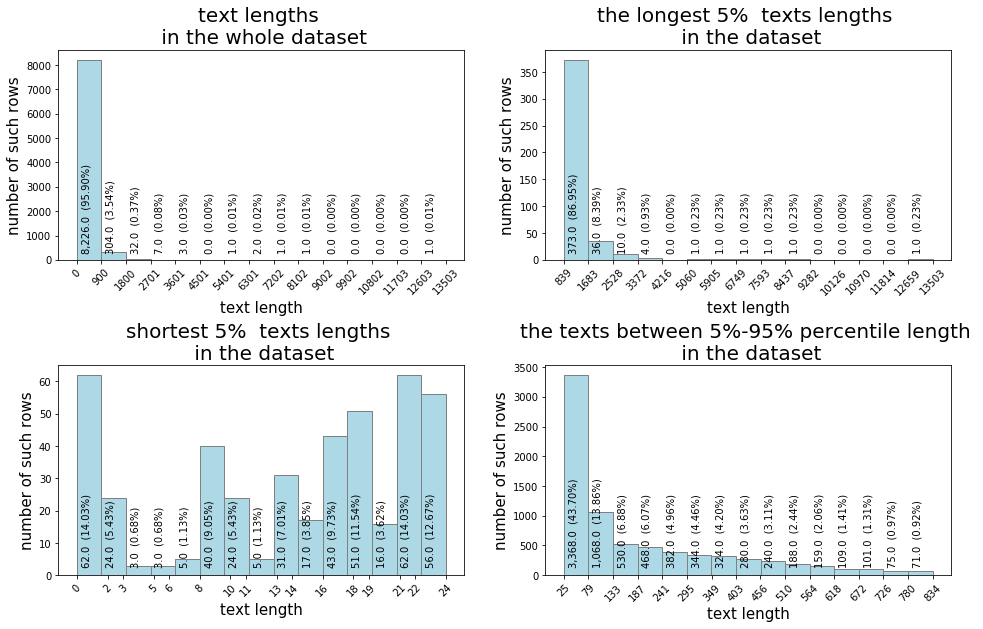

In [55]:
hist_with_perc(log_cols['textLength'], 15,'text lengths \n in the whole dataset','text length','number of such rows','lightblue'
            , log_cols[log_cols['textLength']>=cut_val_top_length]['textLength'],15,'the longest 5%  texts lengths \n in the dataset'
            , log_cols[log_cols['textLength']<=cut_val_bottom_length]['textLength'],15,'shortest 5%  texts lengths \n in the dataset'
            , log_cols[(log_cols['textLength']<cut_val_top_length)&(log_cols['textLength']>cut_val_bottom_length)].textLength,15,'the texts between 5%-95% percentile length \n in the dataset')

**After analysis, need to decide to remove certain percent of the longest and shortest texts.**
Currently, plan to remove top 1% and bottom 2% of rows. 
<hr/>
*Remove the rows which have too long and too short texts code below*

In [24]:
#detect the number of rows that fall in top % and bottom %
top= 0.01
bottom = 0.02
cutoff_percent_top = round((int(log_cols.shape[0]) * top))
cutoff_percent_bottom = round((int(log_cols.shape[0]) * bottom))
print('Total number of rows in dataset:', str(log_cols.shape[0]))
print('Number of top '+str(round(top*100))+'% of the rows: ', str(cutoff_percent_top))
print('Number of bottom '+str(round(bottom*100))+'% of the rows: ', str(cutoff_percent_bottom))

value_Longest = log_cols.sort_values('textLength', ascending=False).head(cutoff_percent_top).iloc[cutoff_percent_top-1].textLength
value_shortest = log_cols.sort_values('textLength', ascending=True).head(cutoff_percent_bottom).iloc[cutoff_percent_bottom-1].textLength

print('length of the text, above which to filter out the rows: ', str(value_Longest))
print('length of the text, below which to filter out the rows: ', str(value_shortest))

#log_cols[log_cols['textLength']<=value_shortest].to_csv('shortest_3pct.csv')
#log_cols[log_cols['textLength']>=value_Longest].to_csv('longest_7pct.csv')

Total number of rows in dataset: 8578
Number of top 1% of the rows:  86
Number of bottom 2% of the rows:  172
length of the text, above which to filter out the rows:  1504
length of the text, below which to filter out the rows:  13


In [25]:
log_cut = log_cols[(log_cols['textLength']>value_shortest) & (log_cols['textLength']<value_Longest)]

<h3> 1.6 Combine all texts by developers </h3><br>
group the texts together that are manually written by the same developer in the same project. The whole texts willbe used as an input for third-party personality insights API. 

In [26]:

# loop through the projects, then through the authors and combine the texts written by the given author in the given project
# store the project, author and text data into series and form a data frame.

df_proj_name = []
df_user_name = []
df_user_text = []
df_texts_count = []
df_texts_length = []
df_words_in_text = []
for project in log_cut['project'].unique():
    for dev_user in log_cut[log_cut['project']==project]['author'].unique():
        user_txt = ''       
        texts_count = 0
        texts_length = 0
        words_in_text = 0
        curr_df = log_cut[(log_cut['project']==project) & (log_cut['author']==dev_user)]
        for index, row in curr_df.iterrows():
            user_txt = str(user_txt) + str(row['text']) + '. '
            texts_count = texts_count + 1
            texts_length = texts_length + len(row['text'])
            words_in_text = words_in_text + len(row['text'].split()) 
        df_proj_name.append(project)
        df_user_name.append(dev_user)
        df_user_text.append(user_txt)
        df_texts_count.append(texts_count)
        df_texts_length.append(texts_length)
        df_words_in_text.append(words_in_text)
    
user_text_combined = pd.DataFrame({'project':df_proj_name,
                   'user':df_user_name, 
                   'text':df_user_text,
                    'count_of_texts':df_texts_count,
                    'words_in_text':df_words_in_text,
                    'texts_length':df_texts_length})
     
user_text_combined.to_csv('user_text_combined.csv')
print(user_text_combined.shape)
user_text_combined.head(3)

(618, 6)


,project,user,text,count_of_texts,words_in_text,texts_length
0,xd,aliiqbal,Cant completely remove custom module after put...,1,9,64
1,xd,grussell,Custom conversion is broken. If the custom doe...,59,1891,11088
2,xd,dgarcia,If I try to use when developing a Spring XD mo...,1,30,152


**<font color="red">!!! Important notice</font>** IBM Watson says that minimum of 600 words are required for the proper personality report.

In [27]:
user_text_combined[user_text_combined['words_in_text']>=600].shape[0]

108

<h3>Combine the texts of the users, that are present in different projects.</h3>

get the unique users per Name(displayName), Email(emailAddress), Username(name), Project(project)

In [28]:
users_df = users[['displayName','emailAddress','name','project']]
users_df = users_df[['displayName','emailAddress','name','project']].drop_duplicates()

Merge the users dataframe with the user_texts dataframe with username and project code <br/>
Clean the email addresses, to match one normalized format.

In [29]:
user_all_texts_emails = pd.merge(user_text_combined, users_df, how = 'left',
                                   left_on = ['project', 'user'],
                                   right_on = ['project', 'name'])[['project','user','text','count_of_texts','words_in_text','texts_length','emailAddress']]
user_all_texts_emails['emailAddress'] = user_all_texts_emails['emailAddress'].str.replace(' dot org', '.org')
user_all_texts_emails['emailAddress'] = user_all_texts_emails['emailAddress'].str.replace(' dot io', '.io')
user_all_texts_emails['emailAddress'] = user_all_texts_emails['emailAddress'].str.replace(' dot me', '.me')
user_all_texts_emails['emailAddress'] = user_all_texts_emails['emailAddress'].str.replace(' dot com', '.com')
user_all_texts_emails['emailAddress'] = user_all_texts_emails['emailAddress'].str.replace(' dot fr', '.fr')
user_all_texts_emails['emailAddress'] = user_all_texts_emails['emailAddress'].str.replace(' dot ', '.')
user_all_texts_emails['emailAddress'] = user_all_texts_emails['emailAddress'].str.replace(' at ', '@')
user_all_texts_emails['emailAddress'] = user_all_texts_emails['emailAddress'].str.replace(' ', '')

Identify the users with emails, that are present in more than one project.<br/>
Identify the users with emails, that are present in only one project. <br />
identify the users with no emails.<br>
For the users that are present in more than one project, combine texts from all projects, and update the number of words/textlength columns.

In [30]:
users_proj = user_all_texts_emails[['user', 'emailAddress', 'project']].groupby(['user', 'emailAddress']).count()
users_proj.reset_index(level= [0,1], inplace=True)

users_with_duplicates = users_proj[users_proj['project']>1][['user', 'emailAddress']]
users_with_single = users_proj[users_proj['project']==1][['user', 'emailAddress']]
users_with_single_noemail=user_all_texts_emails[pd.isnull(user_all_texts_emails.emailAddress)==True][['user', 'emailAddress']]

for i in range(0, users_with_duplicates.shape[0]):
    user_name = users_with_duplicates.iloc[i]['user']
    user_email = users_with_duplicates.iloc[i]['emailAddress']   
    df = (user_all_texts_emails[(user_all_texts_emails['user']==user_name) & (user_all_texts_emails['emailAddress']==user_email)])
    text_=''
    count_of_texts_=0
    words_in_text_=0
    texts_length_=0
    for k in range(0, df.shape[0]):
        text_ = text_ + df.iloc[k]['text']
        count_of_texts_ = count_of_texts_ + df.iloc[k]['count_of_texts']
        words_in_text_ = words_in_text_ + df.iloc[k]['words_in_text']
        texts_length_ = texts_length_ + df.iloc[k]['texts_length']
    user_all_texts_emails.loc[(user_all_texts_emails['user']==user_name) 
                              & (user_all_texts_emails['emailAddress']==user_email), 'text']=text_
    user_all_texts_emails.loc[(user_all_texts_emails['user']==user_name) 
                              & (user_all_texts_emails['emailAddress']==user_email), 'count_of_texts']=count_of_texts_
    user_all_texts_emails.loc[(user_all_texts_emails['user']==user_name) 
                              & (user_all_texts_emails['emailAddress']==user_email), 'words_in_text']=words_in_text_
    user_all_texts_emails.loc[(user_all_texts_emails['user']==user_name) 
                              & (user_all_texts_emails['emailAddress']==user_email), 'texts_length']=texts_length_

Check, after these changes, how many users are valid for IBM Watson Personality Insights check

In [31]:
print('before these changes: ', user_text_combined[user_text_combined['words_in_text']>=600].shape[0], '\n',
      'after these changes: ', user_all_texts_emails[user_all_texts_emails['words_in_text']>=600].shape[0])

before these changes:  108 
 after these changes:  136


In [32]:
user_all_texts_emails[user_all_texts_emails['words_in_text']>=600].head()

,project,user,text,count_of_texts,words_in_text,texts_length,emailAddress
1,xd,grussell,Custom conversion is broken. If the custom doe...,59,1891,11088,grussell@gopivotal.com
3,xd,mark.pollack,Update Spring-AMQP to RabbitMQ Client to. Enab...,340,6429,38305,mpollack@gopivotal.com
4,xd,david_geary,"All modules that allow groovy (filter, script,...",7,886,5063,d.geary@sophiasearch.com
5,xd,dturanski,User provides a jar file exposing a custom bea...,57,1409,8615,dturanski@gopivotal.com
6,xd,sabby,Spring flo issue with unexpected char. As a de...,390,7131,41490,sanandan@pivotal.io


<h3> Identify duplicated users accounts and show the unique users that meet words coutn criteria of IBM Watson </h3>

Get the users with texts that match IBM Watson criteria - minimum 600 words. 

In [33]:
valid_user_texts = user_all_texts_emails[user_all_texts_emails['words_in_text']>=600]

In [34]:
print(valid_user_texts.shape[0])
valid_user_texts.head(3)

136


,project,user,text,count_of_texts,words_in_text,texts_length,emailAddress
1,xd,grussell,Custom conversion is broken. If the custom doe...,59,1891,11088,grussell@gopivotal.com
3,xd,mark.pollack,Update Spring-AMQP to RabbitMQ Client to. Enab...,340,6429,38305,mpollack@gopivotal.com
4,xd,david_geary,"All modules that allow groovy (filter, script,...",7,886,5063,d.geary@sophiasearch.com


Some users have emailAddress value missing ('NaN'), we need to transform NaN value to '-' to make sure duplicates and group_by functions work properly.

In [60]:
valid_user_texts.loc[pd.isnull(valid_user_texts.emailAddress)==True,'emailAddress'] = '-'
#valid_user_texts[['user','emailAddress']].drop_duplicates().to_csv('valid_users_unique.csv')
print('Total number of unique users in valid user texts dataset: ', valid_user_texts[['user','emailAddress']].drop_duplicates().shape[0])
valid_user_texts[['user','emailAddress']].drop_duplicates().head(3)

Total number of unique users in valid user texts dataset:  100


,user,emailAddress
1,grussell,grussell@gopivotal.com
3,mark.pollack,mpollack@gopivotal.com
4,david_geary,d.geary@sophiasearch.com


Now, let's see the unique users per each project

In [36]:
#valid_user_texts.groupby(['project']).count().to_csv('project_users.csv')
valid_user_texts[['project', 'user']].groupby(['project']).count().sort_values('user', ascending=False)

,user
project,
tistud,33
timob,30
dnn,20
xd,15
mesos,12
nexus,11
apstud,10
mule,5


<h2>Prepare data for watson</h2>

Get the unique users and their texts.

In [37]:
valid_user_texts_unique = valid_user_texts[['user','emailAddress', 'text']].drop_duplicates()
print(valid_user_texts_unique.shape[0])
valid_user_texts_unique.head()

100


,user,emailAddress,text
1,grussell,grussell@gopivotal.com,Custom conversion is broken. If the custom doe...
3,mark.pollack,mpollack@gopivotal.com,Update Spring-AMQP to RabbitMQ Client to. Enab...
4,david_geary,d.geary@sophiasearch.com,"All modules that allow groovy (filter, script,..."
5,dturanski,dturanski@gopivotal.com,User provides a jar file exposing a custom bea...
6,sabby,sanandan@pivotal.io,Spring flo issue with unexpected char. As a de...


In [38]:
#valid_user_texts_unique.to_csv('valid_user_texts_unique.csv')

In [39]:
valid_user_texts_unique.head()

,user,emailAddress,text
1,grussell,grussell@gopivotal.com,Custom conversion is broken. If the custom doe...
3,mark.pollack,mpollack@gopivotal.com,Update Spring-AMQP to RabbitMQ Client to. Enab...
4,david_geary,d.geary@sophiasearch.com,"All modules that allow groovy (filter, script,..."
5,dturanski,dturanski@gopivotal.com,User provides a jar file exposing a custom bea...
6,sabby,sanandan@pivotal.io,Spring flo issue with unexpected char. As a de...


<h2> Get IBM Watson personality insight results </h2>

In [40]:
from __future__ import print_function
import json
from os.path import join, dirname
from ibm_watson import PersonalityInsightsV3
import csv
import os
from datetime import datetime

service = PersonalityInsightsV3(
    version='2017-10-13',
    ## url is optional, and defaults to the URL below. Use the correct URL for your region.
    url='https://gateway-lon.watsonplatform.net/personality-insights/api',
    iam_apikey='oUImnq_VXfyDypESNM8rmtJOpzUzg6Zsp_TnZxmwHotR')

'''
another account credentials:
BFsOsCFLvQgZHLicoAj_ywnJ_92h0ry0gTgKudmuDmjm
https://gateway-lon.watsonplatform.net/personality-insights/api
'''

'\nanother account credentials:\nBFsOsCFLvQgZHLicoAj_ywnJ_92h0ry0gTgKudmuDmjm\nhttps://gateway-lon.watsonplatform.net/personality-insights/api\n'

In [41]:
retrieve = 0
#retrieve parameter, set to 1 to retrieve IBM Watson results again. set to 0 to use already retrieved and saved dataframe.

if retrieve ==1:
    user_personalities = pd.DataFrame(columns=('user', 'emailAddress', 
                                               'openness', 'o_raw', 'o_sign',
                                               'conscientiousness', 'c_raw', 'c_sign',
                                               'extraversion', 'e_raw', 'e_sign',
                                               'agreeableness', 'a_raw', 'a_sign',
                                               'neuroticism', 'n_raw', 'n_sign'))

    for i in range(0, valid_user_texts_unique.shape[0]):
        user_ = valid_user_texts_unique.iloc[i]['user']
        email_ = valid_user_texts_unique.iloc[i]['emailAddress']
        text_ = valid_user_texts_unique.iloc[i]['text']

        # define destination json structure Save input JSON file for each user 
        data = {}
        data['contentItems'] = []
        data['contentItems'].append({
            'content': text_,
            'contenttype': 'application/json',
            'created': datetime.now().toordinal(),
            'id': i,
            'language':'en',
            'user_name':user_,
            'email':email_
        })

        input_json_file = 'json_input/' + user_ + ';' + email_ + '.json'
        with open(input_json_file, 'w') as outfile:
            json.dump(data, outfile)

        # Call IBM Watson Personality Insights for each user 
        with open(join(dirname('__file__'), input_json_file)) as \
            profile_json:
            profile = service.profile(
            profile_json.read(),
            'application/json',
            raw_scores=True,
            consumption_preferences=False).get_result()

        # Save the personality insights result into output JSON file for each user
        output_json_file = 'json_output/' + user_ + ';' + email_ + '_result.json'
        with open(output_json_file, 'w') as outfile:
            json.dump(profile, outfile)

        # parse JSON, loop through each personality and get the scores
        personalities = []
        for p in range(0, 5):
            trait_id = profile['personality'][p]['name']
            percentile = profile['personality'][p]['percentile']
            significant = profile['personality'][p]['significant']
            raw_score = profile['personality'][p]['raw_score']

            if trait_id == 'Openness':
                big5_openness = percentile
                big5_o_raw = raw_score
                big5_o_sign = significant
            elif trait_id=='Conscientiousness':
                big5_conscientiousness = percentile
                big5_c_raw = raw_score
                big5_c_sign = significant
            elif trait_id == 'Extraversion':
                big5_extraversion = percentile
                big5_e_raw = raw_score
                big5_e_sign = significant
            elif trait_id == 'Agreeableness':
                big5_agreeableness = percentile
                big5_a_raw = raw_score
                big5_a_sign = significant
            elif trait_id == 'Emotional range':
                big5_neuroticism = percentile
                big5_n_raw = raw_score
                big5_n_sign = significant

        # Save the user personalities into dataset
        user_personalities = user_personalities.append([{
            'user':user_, 'emailAddress':email_, 
           'openness':big5_openness, 'o_raw':big5_o_raw, 'o_sign':big5_o_sign,
           'conscientiousness':big5_conscientiousness, 'c_raw':big5_c_raw, 'c_sign':big5_c_sign,
           'extraversion':big5_extraversion, 'e_raw':big5_e_raw, 'e_sign':big5_e_sign,
           'agreeableness':big5_agreeableness, 'a_raw':big5_a_raw, 'a_sign':big5_a_sign,
           'neuroticism':big5_neuroticism, 'n_raw':big5_n_raw, 'n_sign':big5_n_sign
        }])
else:
    user_personalities=pd.read_csv('user_personalities.csv')

<hr/><font color="red" size="4">**!!!** read about the raw scores here: </font> <pre>https://cloud.ibm.com/docs/services/personality-insights?topic=personality-insights-numeric#rawScores-numeric </pre><hr/> 

In [42]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
user_personalities.to_csv('user_personalities.csv')
user_personalities.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,Unnamed: 0.1.1.1.1,user,emailAddress,openness,o_raw,o_sign,...,c_sign,extraversion,e_raw,e_sign,agreeableness,a_raw,a_sign,neuroticism,n_raw,n_sign
0,0,0,0,0,0,grussell,grussell@gopivotal.com,0.970,0.809,True,...,True,0.126,0.500,True,0.000,0.590,True,0.102,0.446,True
1,1,1,1,1,0,mark.pollack,mpollack@gopivotal.com,0.945,0.800,True,...,True,0.072,0.486,True,0.000,0.605,True,0.234,0.487,True
2,2,2,2,2,0,david_geary,d.geary@sophiasearch.com,0.965,0.807,True,...,True,0.310,0.529,True,0.002,0.630,True,0.658,0.573,True
3,3,3,3,3,0,dturanski,dturanski@gopivotal.com,0.963,0.806,True,...,True,0.097,0.493,True,0.000,0.606,True,0.115,0.451,True
4,4,4,4,4,0,sabby,sanandan@pivotal.io,0.823,0.778,True,...,True,0.096,0.493,True,0.000,0.610,True,0.314,0.505,True


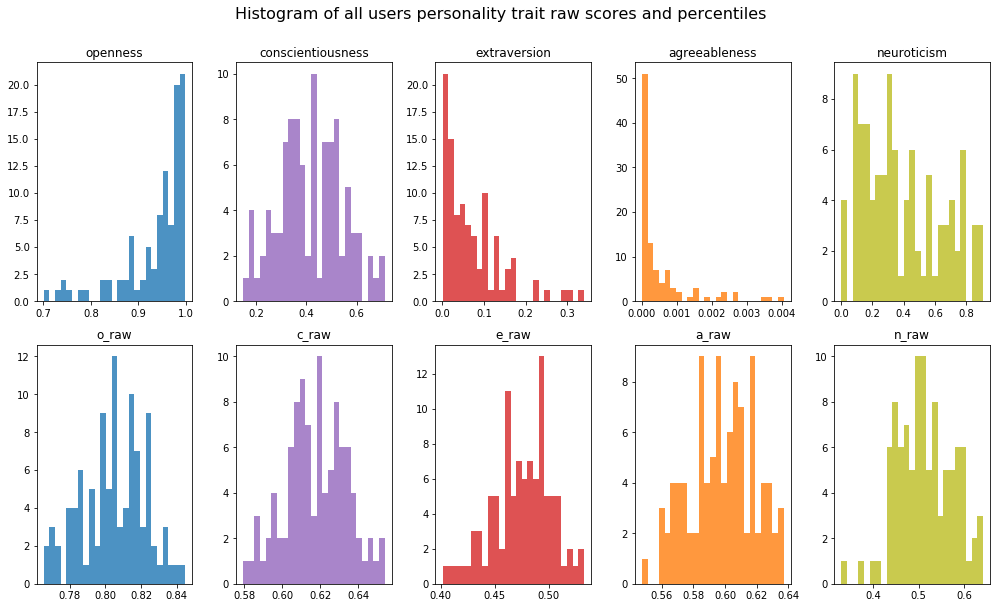

In [65]:
# Plot
fig, axes = plt.subplots(2, 5, figsize=(14,8), sharex=False, sharey=False)
colors = ['tab:blue', 'tab:purple', 'tab:red', 'tab:orange', 'tab:olive',
         'tab:blue', 'tab:purple', 'tab:red', 'tab:orange', 'tab:olive']
traits = ['openness', 'conscientiousness', 'extraversion', 'agreeableness', 'neuroticism',
         'o_raw', 'c_raw', 'e_raw', 'a_raw', 'n_raw']

for i, (axx, trait_) in enumerate(zip(axes.flatten(), traits)):
    x = user_personalities[trait_]
    axx.hist(x, alpha=0.8, bins=25, label=trait_, color=colors[i])
    axx.set_title(trait_)

plt.suptitle('Histogram of all users personality trait raw scores and percentiles', y=1.05, size=16)
plt.tight_layout();
plt.savefig('personalities.jpg')

join the personalities dataframe to projects 

In [44]:
user_personalities.head()
#valid_user_texts['project', 'user', 'emailAddress']
p_cols = ['project']
for col in user_personalities.columns:
    p_cols.append(col)
project_user_personalities = pd.merge(user_personalities, valid_user_texts, how = 'inner',
                                   left_on = ['user', 'emailAddress'],
                                   right_on = ['user', 'emailAddress'])[p_cols]

print(valid_user_texts.shape[0], project_user_personalities.shape[0])

136 136


Let's see the personality traits percentiles and raw scores distribution within the eight projects. <br>
Define and show the plot with the projects/percentiles and scores 

In [83]:
def boxpl(dt, x_cols, y_cols, title):
    n = 1
    x_cnt = len(x_cols)
    y_cnt = len(y_cols)
    figure = plt.figure(figsize=(18, 5 * x_cnt))
    for x_ax in x_cols:
        for i in y_cols:
            ax = figure.add_subplot(x_cnt, y_cnt, n)
            #ax.set_title(i)
            g = sns.boxplot(x = dt[x_ax], y = dt[i])
            g.set_xticklabels(g.get_xticklabels(), rotation=30)
            plt.suptitle(title, size=16)
            plt.subplots_adjust(bottom=0.15, wspace=0.4)
            n = n + 1

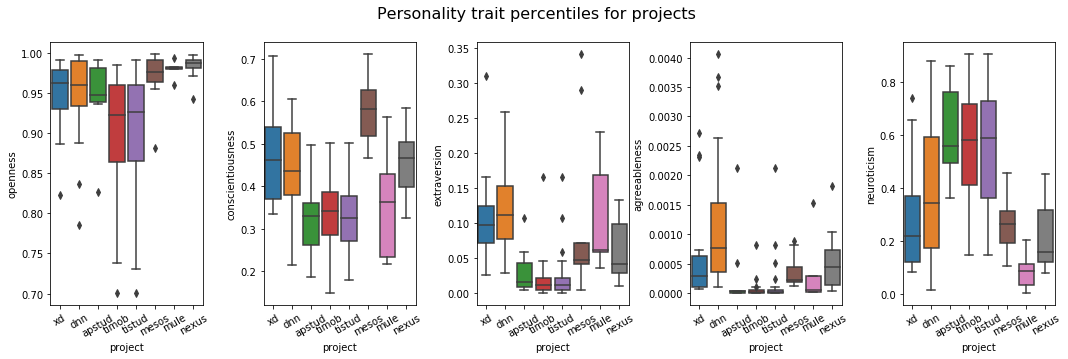

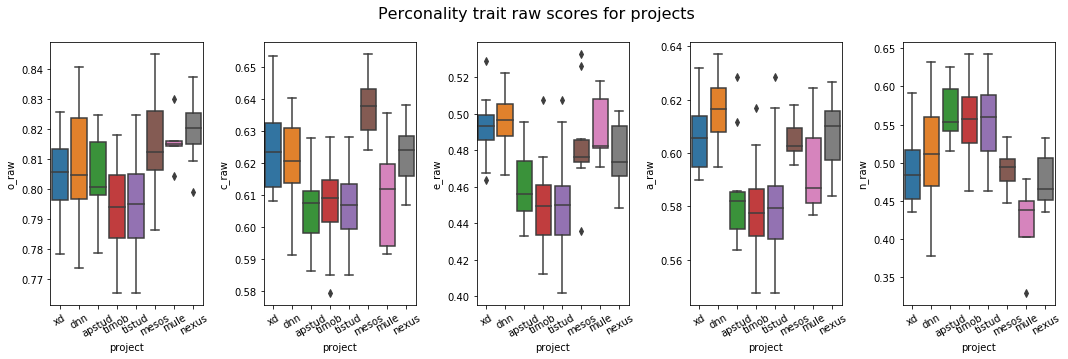

In [84]:
y_cols = ['openness', 'conscientiousness', 'extraversion', 'agreeableness', 'neuroticism']
x_cols = ['project']
title = 'Personality trait percentiles for projects'
boxpl(project_user_personalities, x_cols, y_cols, title)
plt.savefig('personalities_projects_1.jpg')

y_cols = ['o_raw', 'c_raw', 'e_raw', 'a_raw', 'n_raw']
x_cols = ['project']
title = 'Perconality trait raw scores for projects'
boxpl(project_user_personalities, x_cols, y_cols, title)
plt.savefig('personalities_projects_2.jpg')